# **relation italicized text extraction with LSTM model and word2vec embeding**

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional,LSTM,Dense,Embedding
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# **plot_confusion_matrix definition**

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **read and split dataset**

In [0]:
df = pd.read_excel('SemEval2010_task8.xls')

In [8]:
n_most_common_words = 20000 # vocabulary size
max_len = 100
# Initialization
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
# Fit and transformation
tokenizer.fit_on_texts(df['sentences'].values)
sequences = tokenizer.texts_to_sequences(df['sentences'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# Padding
X = pad_sequences(sequences, maxlen=max_len)

Found 25675 unique tokens.


In [0]:
codeOfLabals = []
for i in df['labels']:
    codeOfLabals.append(list(df.labels.unique()).index(i))

In [10]:
df.labels.unique()

array(['Component-Whole', 'Other', 'Instrument-Agency',
       'Member-Collection', 'Cause-Effect', 'Entity-Destination',
       'Content-Container', 'Message-Topic', 'Product-Producer',
       'Entity-Origin'], dtype=object)

In [0]:
labels = to_categorical(codeOfLabals, num_classes=len(df.labels.unique())) # from keras.utils.np_utils

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20, random_state=42)

# **create model**

In [0]:
embedding_size = 300
model = Sequential()
model.add(Embedding(n_most_common_words, embedding_size, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(labels.shape[1], activation='softmax'))

In [0]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['acc'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               439296    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 6,441,866
Trainable params: 6,441,866
Non-trainable params: 0
_________________________________________________________________


fit model

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 73s 2s/step - loss: 2.1690 - acc: 0.2107 - val_loss: 1.9949 - val_acc: 0.2781
Epoch 2/10
40/40 [==============================] - 72s 2s/step - loss: 1.8034 - acc: 0.3570 - val_loss: 1.6993 - val_acc: 0.4039
Epoch 3/10
40/40 [==============================] - 72s 2s/step - loss: 1.3857 - acc: 0.5186 - val_loss: 1.5947 - val_acc: 0.4023
Epoch 4/10
40/40 [==============================] - 73s 2s/step - loss: 1.0515 - acc: 0.6359 - val_loss: 1.5486 - val_acc: 0.4492
Epoch 5/10
40/40 [==============================] - 72s 2s/step - loss: 0.7457 - acc: 0.7604 - val_loss: 1.6153 - val_acc: 0.4938
Epoch 6/10
40/40 [==============================] - 72s 2s/step - loss: 0.5256 - acc: 0.8369 - val_loss: 1.6961 - val_acc: 0.4875
Epoch 7/10
40/40 [==============================] - 72s 2s/step - loss: 0.3621 - acc: 0.8945 - val_loss: 1.5967 - val_acc: 0.5305
Epoch 8/10
40/40 [==============================] - 72s 2s/step - loss: 0.2334 - acc: 0.93

# **reports**

In [18]:
prediction_probas = model.predict(X_test) 
y_pred = [np.argmax(pred) for pred in prediction_probas]
y__test=np.argmax(y_test, axis=1)
labels_n = list(df.labels.unique())
print('classification_report\n'+classification_report(y__test, y_pred, digits=3))

classification_report
              precision    recall  f1-score   support

           0      0.482     0.467     0.474       197
           1      0.315     0.373     0.342       260
           2      0.375     0.485     0.423        99
           3      0.514     0.397     0.448       136
           4      0.738     0.678     0.707       199
           5      0.864     0.646     0.739       158
           6      0.906     0.369     0.525       130
           7      0.621     0.409     0.493       132
           8      0.313     0.647     0.422       153
           9      0.568     0.463     0.510       136

    accuracy                          0.495      1600
   macro avg      0.570     0.493     0.508      1600
weighted avg      0.558     0.495     0.506      1600



Confusion matrix, without normalization


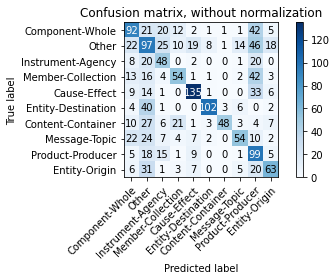

In [19]:
plot_confusion_matrix(y__test,np.array(y_pred),np.array(labels_n))
plt.show()
